# Test Models with memory

To test the models I check whether the constraints imposed are well reproduced.

In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns, matplotlib.pyplot as plt, operator as op
import os

import Utilities
from NaiveTCM import NaiveNetFitness
from PersistenceNetFitnessGlobal import PersistenceNetFitnessGlobal
from PersistenceNetFitness import PersistenceNetFitness
from PersistenceNetFitnesslinks import PersistenceNetFitnesslinks

In [43]:
#cd ../Structural Break and Reconstruction Social Networks/temporal_networks_daily

[Errno 2] No such file or directory: '../Structural Break and Reconstruction Social Networks/temporal_networks_daily'
/home/virginio.clemente/Structural Break and Reconstruction Social Networks/temporal_networks_daily


### Uploading the data

In [101]:
data = []

for file in os.listdir():
    if 'checkpoints' in file: continue
    step = int(file.split('_')[1].split('.')[0])
    matrix = np.genfromtxt(file,delimiter=',')
    G = nx.from_numpy_matrix(matrix)
    data.append([step , G ]) 

data.sort()

# Here I verify that all the models reproduce the constrained features

In [22]:
tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,50)

In [28]:
# I initialize the value of alfa and beta randomly
alfa_rand = np.random.rand(92) 
beta_rand =np.random.rand(92) 

# Model with local Constraints

In [29]:
pnt_likelihood_TCM = PersistenceNetFitness(tnet_synt_all)

pnt_likelihood_TCM.solve(alfa_rand,beta_rand)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


30205.10369099729

### I compute the expected values of k and h w.r.t. the model with local Constraints

In [30]:
k_exp =  np.zeros( pnt_likelihood_TCM.no_nodes )
h_exp =  np.zeros( pnt_likelihood_TCM.no_nodes )

y = pnt_likelihood_TCM.fitness_y
x = pnt_likelihood_TCM.fitness_x
tau = 1

T = pnt_likelihood_TCM.no_steps


lambda_minus = pnt_likelihood_TCM.lambda_minus 
lambda_plus = pnt_likelihood_TCM.lambda_plus
for i in range(pnt_likelihood_TCM.no_nodes):
    for j in range(pnt_likelihood_TCM.no_nodes):
        if i == j:
            continue

        
        root = np.sqrt(np.exp(-1*(np.log(y[i]) + np.log(y[j]))) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))**2 )                   
        sinhB = np.sinh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

        coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

        e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))
        e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

        eJ = np.exp(1/(4)*(np.log(y[i]) + np.log(y[j])))


        sigma_l_t = (sinhB) / ( 2*root) + 1/2 

        k_exp[i] += eJ/(2*(lambda_minus[i,j]**T + lambda_plus[i,j]**T)) * ( lambda_plus[i,j]**(T-1)*(sinhB + (sinhB*coshB)/root ) + lambda_minus[i,j]**(T-1)*(sinhB - (sinhB*coshB)/root )  ) +1/2 # N.T.L.

        h_exp [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]**tau*lambda_plus[i,j]**(T-tau) + lambda_plus[i,j]**tau*lambda_minus[i,j]**(T-tau) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.



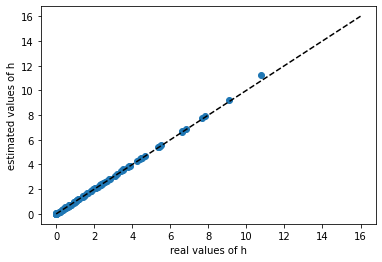

In [31]:
plt.xlabel('real values of h')
plt.ylabel('estimated values of h')
plt.scatter(h_exp,pnt_likelihood_TCM.vec_h)
plt.plot([0, 16], [0, 16], ls="--", c="0")
plt.show()

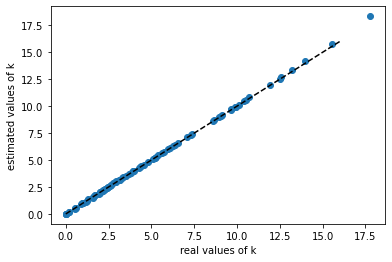

In [32]:
plt.xlabel('real values of k')
plt.ylabel('estimated values of k')
plt.scatter(k_exp,pnt_likelihood_TCM.vec_k)
plt.plot([0, 16], [0, 16], ls="--", c="0")
plt.show()

# Model with constraints on the presisting connectivity $(h_{ij})$

In [33]:
pnt_likelihood_link = PersistenceNetFitnesslinks(tnet_synt_all) 

alfa_random_link = np.random.rand(92) 
beta_random_link =np.random.rand(46*91) 

In [34]:
pnt_likelihood_link.solve(alfa_random_link,beta_random_link)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


27524.24210266507

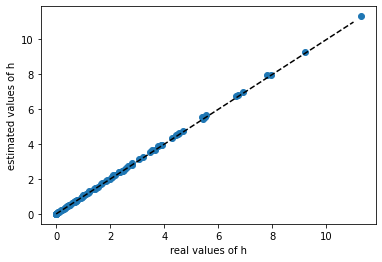

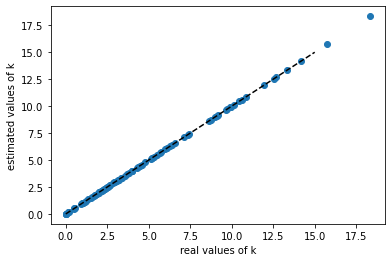

In [35]:
from sklearn.metrics import mean_squared_error

tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,50)

alfa_link = pnt_likelihood_link.fitness_alpha   
beta_link =  pnt_likelihood_link.fitness_beta


y_link = pnt_likelihood_link.fitness_y 
y_matrix = np.zeros((pnt_likelihood_link.no_nodes,pnt_likelihood_link.no_nodes))

ij = 0
for i in range(pnt_likelihood_link.no_nodes):
    for j in range(i):

        y_matrix[i,j] = y_link[ij]
        y_matrix[j,i] = y_matrix[i,j]

        ij +=1

x = pnt_likelihood_link.fitness_x 
n_nodes =  pnt_likelihood_link.no_nodes


k_exp =  np.zeros( pnt_likelihood_link.no_nodes )
h_exp =  np.zeros( pnt_likelihood_link.no_nodes )


T = pnt_likelihood_link.no_steps


lambda_minus = pnt_likelihood_link.lambda_minus 
lambda_plus = pnt_likelihood_link.lambda_plus
for i in range(pnt_likelihood_link.no_nodes):
    for j in range(pnt_likelihood_link.no_nodes):
        if i == j:
            continue

        y_ij = y_matrix[i,j]
        root = np.sqrt(np.exp(-1*(np.log(y_ij, dtype=np.float128)), dtype=np.float128) + np.sinh(1/(2)*(np.log(x[i], dtype=np.float128)+np.log(x[j], dtype=np.float128) +np.log(y_ij) ), dtype=np.float128)**2 )                   
        sinhB = np.sinh(1/(2) * (np.log(x[i], dtype=np.float128)+np.log(x[j], dtype=np.float128) +np.log(y_ij, dtype=np.float128) ), dtype=np.float128)

        coshB = np.cosh(1/(2) * (np.log(x[i], dtype=np.float128)+np.log(x[j], dtype=np.float128) +np.log(y_ij) ), dtype=np.float128)

        e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)
        e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)

        eJ = np.exp(1/(4)*(np.log(y_ij)), dtype=np.float128)

        sigma_l_t = (sinhB) / ( 2*root) + 1/2 

        k_exp[i] += eJ/(2*(lambda_minus[i,j]**T + lambda_plus[i,j]**T)) * ( lambda_plus[i,j]**(T-1)*(sinhB + (sinhB*coshB)/root ) + lambda_minus[i,j]**(T-1)*(sinhB - (sinhB*coshB)/root )  ) +1/2 # N.T.L.

        h_exp [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]*lambda_plus[i,j]**(T-1) + lambda_plus[i,j]*lambda_minus[i,j]**(T-1) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.


plt.scatter(pnt_likelihood_link.vec_h, h_exp)
plt.plot([0, 11], [0, 11], ls="--", c="0")
plt.xlabel('real values of h')
plt.ylabel('estimated values of h')
plt.show()


plt.scatter(pnt_likelihood_link.vec_k, k_exp)
plt.plot([0, 15], [0, 15], ls="--", c="0")
plt.xlabel('real values of k')
plt.ylabel('estimated values of k')
plt.show()


# Model with Global Contraint

### In this case the lagrange multiplier is one and controls the value of the average degree

In [36]:
pnt_likelihood_global = PersistenceNetFitnessGlobal(tnet_synt_all)

In [51]:
alfa_rand_global = np.random.rand(92) 
beta_rand_global = np.random.rand(1)


pnt_likelihood_global.solve(alfa_rand_global,beta_rand_global)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


967.4404158687103

In [105]:
y = pnt_likelihood_global.fitness_y
x = pnt_likelihood_global.fitness_x

k_exp =  np.zeros( pnt_likelihood_global.no_nodes )
h_exp =  np.zeros( pnt_likelihood_global.no_nodes )
h_ave = np.zeros(1)

T = pnt_likelihood_global.no_steps

lambda_plus = pnt_likelihood_global.lambda_plus
lambda_minus = pnt_likelihood_global.lambda_minus            

for i in range(pnt_likelihood_global.no_nodes):
    for j in range(pnt_likelihood_global.no_nodes):
        if i == j:
            continue
            
        root = np.sqrt(np.exp(-1*(np.log(y[0]) + np.log(y[0]))) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j]) +np.log(y[0]) +np.log(y[0])))**2 )                   
        sinhB = np.sinh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[0]) +np.log(y[0])))

        coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[0]) +np.log(y[0])))

        e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y[0]) +np.log(y[0])))
        e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y[0]) +np.log(y[0])))

        eJ = np.exp(1/(4)*(np.log(y[0]) + np.log(y[0])))

        sigma_l_t = (sinhB) / ( 2*root) + 1/2 

        k_exp[i] += eJ/(2*(lambda_minus[i,j]**T + lambda_plus[i,j]**T)) * ( lambda_plus[i,j]**(T-1)*(sinhB + (sinhB*coshB)/root ) + lambda_minus[i,j]**(T-1)*(sinhB - (sinhB*coshB)/root )  ) +1/2 # N.T.L.

        h_exp [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]*lambda_plus[i,j]**(T-1) + lambda_plus[i,j]*lambda_minus[i,j]**(T-1) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.

h_ave =  np.sum(h_exp)/pnt_likelihood_global.no_nodes

In [106]:
h_ave

2.2044464443302725

In [107]:
pnt_likelihood_global.average_h

2.2013043478260874

# Computing AIC Total 

The following contains the list of all the breaks found for each model.

In [45]:
cm_breaks = [0,244] 

dyadic_breaks = [0, 50, 100, 150, 200, 244]

local_breaks = [0, 8, 15, 19, 24, 36, 43, 49, 61, 77, 99, 109, 116, 126, 143, 150, 165, 177, 193, 214, 231, 244]

global_breaks = [0, 8, 15, 18, 24, 31, 36, 43, 49, 60, 63, 68, 77, 99, 109, 116, 126, 134, 142, 150, 165, 177, 193, 214, 231, 244]

### AIC Dyadic Constraints

In [46]:
aic_total_dyadic = 0

for i in range(1,len(dyadic_breaks)):

    tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data[dyadic_breaks[i-1]:dyadic_breaks[i]],0,len(data))
    
    pnt_likelihood_link = PersistenceNetFitnesslinks(tnet_synt_all)
    
    likelihood_link = pnt_likelihood_link.solve(alfa_random_link,beta_random_link)
    
    aic_total_dyadic += Utilities.AIC(-likelihood_link,(len(alfa_random_link)+(46*91))*2)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:198: RuntimeWarning: overflow encountered in power
  np.power(self.lambda_plus[i, j], T, dtype=np.float64) + np.power(
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:219: RuntimeWarning: overflow encountered in power
  np.power(self.lambda_plus[i, j], T, dtype=np.float64) + np.power(


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [47]:
print(aic_total_dyadic)

336021.35131644516


### AIC Local Constraints

In [48]:
AIC_tot_local = 0

for t_break in range(len(local_breaks)-1):
    
    input_data = data[local_breaks[t_break]:local_breaks[t_break+1]]
    
    tnet_synt = Utilities.TemporalNetworkLoaderSynt(input_data,0,len(input_data))
    
    pnt_likelihood_local = PersistenceNetFitness(tnet_synt)
    
    likelihood_local = pnt_likelihood_local.solve(alfa_rand,beta_rand)
    
    AIC_local = Utilities.AIC(-likelihood_local,2*len(alfa_rand))
    
    AIC_tot_local += AIC_local
    

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR

In [49]:
print(AIC_tot_local)

268522.79393198807


### AIC Global Constrains

In [52]:
AIC_tot_global = 0

for t_break in range(len(global_breaks)-1):
    
    input_data = data[global_breaks[t_break]:global_breaks[t_break+1]]
    
    tnet_synt = Utilities.TemporalNetworkLoaderSynt(input_data,0,len(input_data))
    
    pnt_likelihood_global = PersistenceNetFitnessGlobal(tnet_synt)
    
    likelihood_global = pnt_likelihood_global.solve(alfa_rand,beta_rand_global)
    
    AIC_global = Utilities.AIC(-likelihood_global,len(alfa_rand)+1)
    
    AIC_tot_global += AIC_global
    

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR

In [53]:
print(AIC_tot_global)

272456.5532256635


### AIC No memory CM 

In [62]:
AIC_tot_CM = 0

for t_break in range(len(cm_breaks)-1):

    input_data_cm = data[cm_breaks[t_break]:cm_breaks[t_break+1]]

    tnet_cm = Utilities.TemporalNetworkLoaderSynt(input_data_cm,0,len(input_data_cm))

    pnt_likelihood_local = PersistenceNetFitness(tnet_cm)

    pnt_likelihood_CM = NaiveNetFitness(tnet_cm)

    x_cm =  pnt_likelihood_CM.solve_eq()

    alfa_naive_all = [i  if i < np.infty else 1  for i in (-np.log(x_cm)) ]

    beta_naive_all = [1 for i in range(len(x_cm))]
    
    AIC_CM = Utilities.AIC(-pnt_likelihood_local.fun_likelihood(np.concatenate((alfa_naive_all,beta_naive_all))),len(alfa_naive_all))
    
    AIC_tot_CM += AIC_CM

print('AIC:')
print(AIC_tot_CM)

`gtol` termination condition is satisfied.
Function evaluations 13, initial cost 1.1679e+04, final cost 1.7017e-09, first-order optimality 2.39e-06.
`gtol` termination condition is satisfied.
AIC:
1398430.2895445474


<ipython-input-62-7dfe36154fba>:15: RuntimeWarning: divide by zero encountered in log
  alfa_naive_all = [i  if i < np.infty else 1  for i in (-np.log(x_cm)) ]


### Here I compute the eigenvalues for the Model with constraints at node level

In [106]:
list_periods = [[36,43],[77,99],[193,214]]

period = 2

input_data = data[list_periods[period][0]:list_periods[period][1]]


tnet_synt = Utilities.TemporalNetworkLoaderSynt(input_data,0,len(input_data))
pnt_likelihood_TCM = PersistenceNetFitness(tnet_synt)

likelihood_pnt = pnt_likelihood_TCM.solve(alfa_rand,beta_rand)
    
x_all = pnt_likelihood_TCM.fitness_x
y_all = pnt_likelihood_TCM.fitness_y

T = pnt_likelihood_TCM.no_steps 


lambda_plus = pnt_likelihood_TCM.lambda_plus
lambda_minus = pnt_likelihood_TCM.lambda_minus

M = []

tau = 1

for i in range(pnt_likelihood_TCM.no_nodes):
    for j in range(pnt_likelihood_TCM.no_nodes):
        if i == j:
            continue   
        
        root = np.sqrt(np.exp(-1*(np.log(y_all[i]) + np.log(y_all[j]))) + np.sinh(1/(2)*(np.log(x_all[i])+np.log(x_all[j]) +np.log(y_all[i]) +np.log(y_all[j])))**2 )                   
        sinhB = np.sinh(1/(2) * (np.log(x_all[i],dtype=np.float128)+np.log(x_all[j],dtype=np.float128) +np.log(y_all[i],dtype=np.float128) +np.log(y_all[j],dtype=np.float128)),dtype=np.float128)
        
        coshB = np.cosh(1/(2) * (np.log(x_all[i])+np.log(x_all[j]) +np.log(y_all[i]) +np.log(y_all[j])))

        e_2B = np.exp(-1 * (np.log(x_all[i])+np.log(x_all[j]) +np.log(y_all[i]) +np.log(y_all[j])))
        e_B = np.exp(-1/2 * (np.log(x_all[i])+np.log(x_all[j]) +np.log(y_all[i]) +np.log(y_all[j])))

        eJ = np.exp(1/(4)*(np.log(y_all[i]) + np.log(y_all[j])))
        e2J = np.exp(1/(2)*(np.log(y_all[i],dtype=np.float128) + np.log(y_all[j],dtype=np.float128)),dtype=np.float128)
        e4J = np.exp( (np.log(y_all[i],dtype=np.float128) + np.log(y_all[j],dtype=np.float128)),dtype=np.float128)

        root_2 = np.sqrt(1+e4J*sinhB**2,dtype=np.float128)

        sigma_l_t = (sinhB) / ( 2*root) + 1/2 


        p_ij = (e2J*sinhB/(2*root_2)) * (np.power(lambda_plus[i,j],T,dtype=np.float128)- np.power(lambda_minus[i,j],T,dtype=np.float128))/(np.power(lambda_plus[i,j],T,dtype=np.float128)+np.power(lambda_minus[i,j],T,dtype=np.float128)) + 1/2

        q_ij = sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(np.power(lambda_minus[i,j],tau,dtype=np.float128)*np.power(lambda_plus[i,j],T-tau,dtype=np.float128) + np.power(lambda_plus[i,j],tau,dtype=np.float128)*np.power(lambda_minus[i,j],T-tau,dtype=np.float128) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) 
       

        if p_ij == 1:

            M_ij = [[i,j],[0, 0],[0,0]]

        else:
            M_ij = [[i,j],[q_ij/p_ij, (p_ij-q_ij)/p_ij],[(p_ij-q_ij)/(1-p_ij),(1-2*p_ij + q_ij)/(1-p_ij)]]
        
        M.append(M_ij)



CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [107]:
import scipy.linalg as la

autovalori_medi = []
autovalori_massimo = []
autovalori_89 = [] 
autovalori_6 = [] 
autovalori_1 = [] 



for i in range(pnt_likelihood_TCM.no_nodes):
    
    nodo_i = M[91*i:91*(i+1)]
    autovalori_2 = []
    
    for el in range(len(nodo_i)):

        A = nodo_i[el][1:]
        eigvals, eigvecs = la.eig(A)

        autovalori_2.append(sorted(eigvals,reverse=True)[1])
    if i == 1:
        autovalori_1.append(np.real(autovalori_2)) 
    if i== 89:
        autovalori_89.append(np.real(autovalori_2))
    if i == 6:
        autovalori_6.append(np.real(autovalori_2))
        
    media_autovalori_2 = np.sum(autovalori_2)/len(autovalori_2)
    massimo_autovalori_2 = np.max(autovalori_2)
    autovalori_medi.append(media_autovalori_2)
    autovalori_massimo.append(massimo_autovalori_2)


In [108]:
autovalori_medi_real = [autovalori_medi[i].real for i in range(len(autovalori_medi))   ]
autovalori_medi_real = np.asarray(autovalori_medi_real)

In [89]:
#autovalori_dict_medi = {}

autovalori_dict_medi['T3'] = autovalori_medi_real

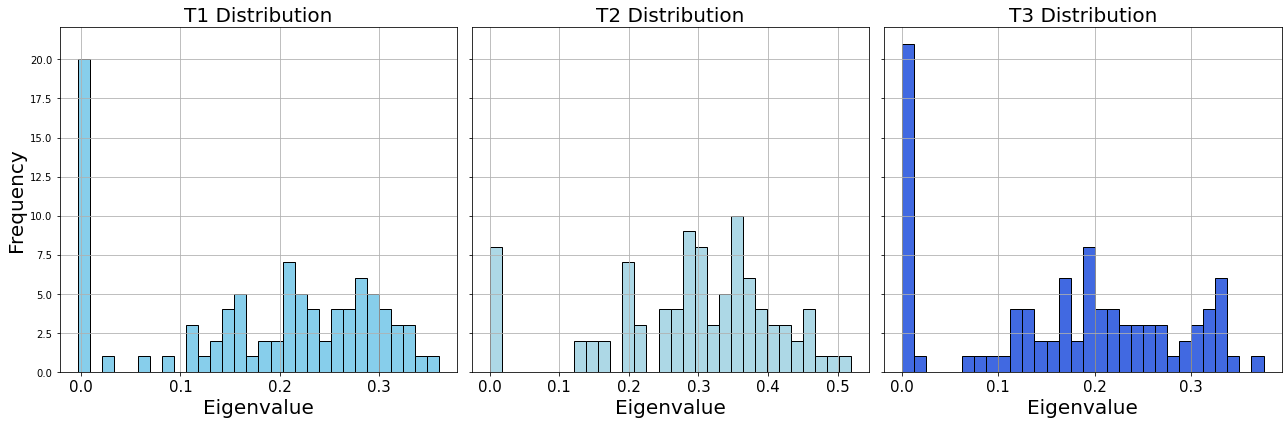

In [90]:
fontsize = 20

d1 = autovalori_dict_medi['T1']
d2 = autovalori_dict_medi['T2']
d3 = autovalori_dict_medi['T3']

# Plotting the histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Histogram for d1
axs[0].hist(d1, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('T1 Distribution',fontsize=fontsize)
axs[0].set_xlabel('Eigenvalue',fontsize=fontsize)
axs[0].set_ylabel('Frequency',fontsize=fontsize)
axs[0].tick_params(axis='x', labelsize=15)
axs[0].grid(True)

# Histogram for d2
axs[1].hist(d2, bins=30, color='lightblue', edgecolor='black')
axs[1].set_title('T2 Distribution',fontsize=fontsize)
axs[1].set_xlabel('Eigenvalue',fontsize=fontsize)
axs[1].tick_params(axis='x', labelsize=15)
axs[1].grid(True)

# Histogram for d3
axs[2].hist(d3, bins=30, color='royalblue', edgecolor='black')
axs[2].set_title('T3 Distribution',fontsize=fontsize)
axs[2].set_xlabel('Eigenvalue',fontsize=fontsize)
axs[2].tick_params(axis='x', labelsize=15)
axs[2].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [109]:
#nodes_dict['Node 1'].append(autovalori_1[0])
#nodes_dict['Node 6'].append(autovalori_6[0])
#nodes_dict['Node 89'].append(autovalori_89[0])

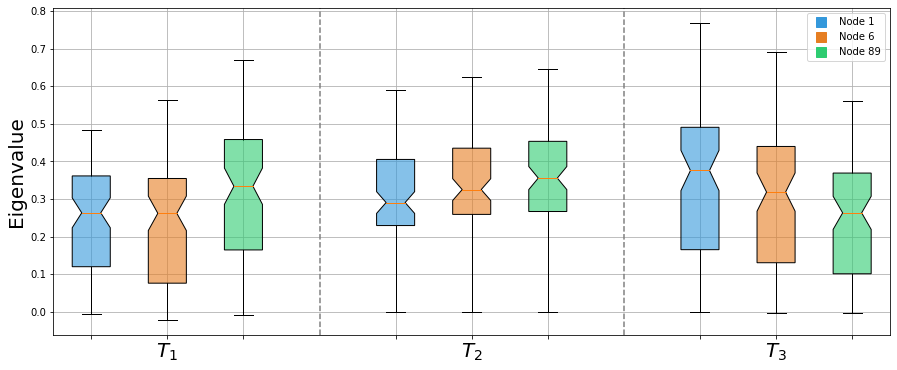

In [110]:
from matplotlib.colors import to_rgba

colors = ['#3498db', '#e67e22', '#2ecc71']

data_periodi = []
labels_periodi = []
colors_periodi = []

alpha = 0.6  
colors_rgba = [to_rgba(color, alpha) for color in colors]  


for period in range(3):
    for i, (node, distributions) in enumerate(nodes_dict.items()):
        data_periodi.append(distributions[period])
        labels_periodi.append(f"{node} - T{period+1}")
        colors_periodi.append(colors[i])

positions = []
current_position = 1
for i in range(len(data_periodi)):
    positions.append(current_position)
    current_position += 1
    if (i + 1) % 3 == 0:
        current_position += 1 

plt.figure(figsize=(15, 6))
box = plt.boxplot(data_periodi, patch_artist=True, positions=positions,notch=True)

for i, patch in enumerate(box['boxes']):
    color_index = i % 3  
    patch.set_facecolor(colors_rgba[color_index])

line_positions = [(positions[i * 3 - 1] + positions[i * 3]) / 2 for i in range(1, 3)]
for pos in line_positions:
    plt.axvline(x=pos, color='grey', linestyle='--')


    
new_labels = [''] * len(positions)
for i in range(3):
    center_position = i * 3 + 1  
    if center_position < len(new_labels):
        new_labels[center_position] = f"$T_{i+1}$"

plt.xticks(positions, new_labels,fontsize=20)
    
    
patches = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, markerfacecolor=color) for color in colors]
plt.legend(patches, ["Node 1", "Node 6", "Node 89"], loc='upper right')

    
plt.ylabel("Eigenvalue",fontsize=20)
plt.grid(True)
plt.show()


# Here, I plot the actual structural breakpoints compared to those detected by the best model.

In [63]:
lista_date = pd.date_range(start="2004-08-30",end="2005-05-02").strftime('%Y-%m-%d')

In [64]:
lista_eventi_reali = ['2004-09-07','2004-09-14','2004-09-24','2004-10-08','2004-10-15','2004-11-01',
                      
                      '2004-11-11','2004-11-17','2004-11-25','2004-12-01','2004-12-09','2004-12-13',
                     
                      '2004-12-18','2005-01-03','2005-01-10','2005-01-31','2005-02-18','2005-03-07',
                      
                      '2005-03-21','2005-03-28','2005-04-07','2005-04-18','2005-04-21'
                     ]

In [65]:
lista_breaks_predicted = [0, 8, 15, 19, 24, 36, 43, 49, 61, 77, 99, 109, 116, 126, 143, 150, 165, 177, 193, 214, 231, 244]


In [66]:
date_predicted = []
for i in lista_breaks_predicted:
    date_predicted.append(lista_date[i])


In [67]:
point_predicted = [1 if el in date_predicted else 0 for el in lista_date]

point_real = [1 if el in lista_eventi_reali else 0 for el in lista_date]

In [68]:
date_x = [el if el in lista_eventi_reali else '' for el in lista_date]

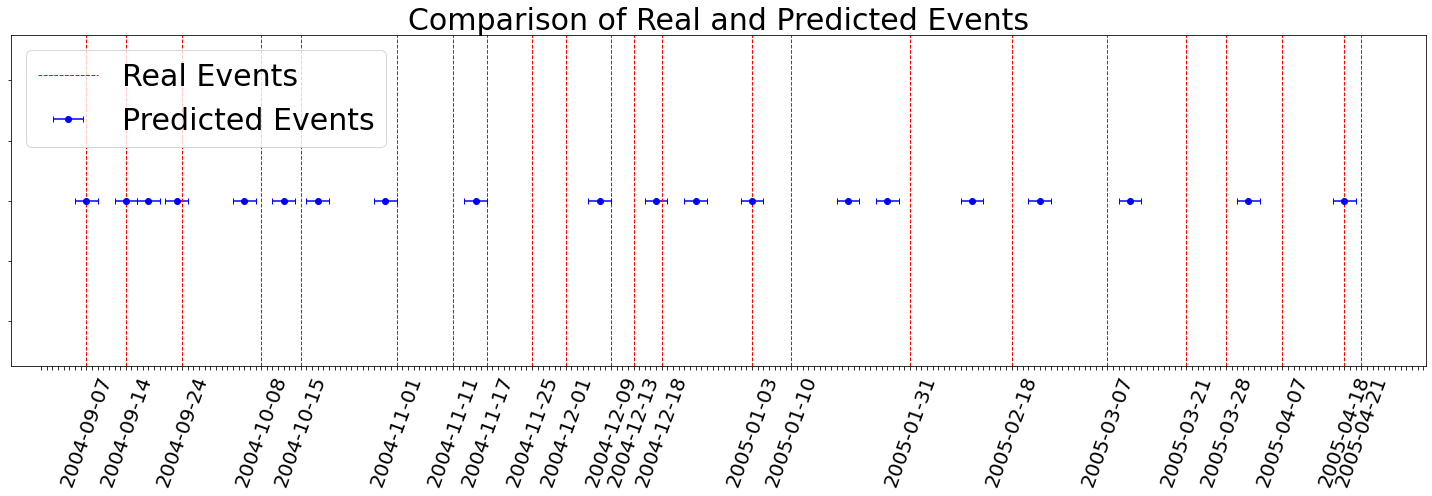

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(20, 7))

# Vertical lines for actual events
for date in lista_eventi_reali:
    ax.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1, label='Real Events')

# Dots with horizontal bars for predicted events
# bars to ±2 days
for index in lista_breaks_predicted:
    if 1 < index < len(lista_date) - 2:  
        date_center = mdates.date2num(pd.to_datetime(lista_date[index]))
        error = mdates.date2num(pd.to_datetime(lista_date[index]) + pd.Timedelta(days=2)) - date_center
        ax.errorbar(date_center, 1, xerr=error, fmt='o', color='blue', capsize=3, label='Predicted Events')

plt.xticks(mdates.date2num(pd.to_datetime(lista_date)), date_x)
plt.xticks(rotation=70,size=20)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),fontsize=30)

ax.set_title('Comparison of Real and Predicted Events',size=30)
ax.set_yticklabels([])

plt.tight_layout()
plt.show()
